# 3.3 Guided Backpropagation

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_3 import MNIST_CNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/3_3_GBP/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


![title](./assets/2_5_GBP/fig1.png)

In [ ]:
# https://stackoverflow.com/questions/38340791/guided-back-propagation-in-tensorflow

grad = tf.placeholder(tf.float32, [2,2])
feat = tf.placeholder(tf.float32, [2,2])

# Forward pass
frwd = tf.nn.relu(feat)

# Gradient calculation using backpropagation
res1 = gen_nn_ops._relu_grad(grad, feat)

# Gradient calculation using deconvolution
res2 = tf.nn.relu(grad)

# Gradient calculation using guided backpropagation
res3 = tf.where(0. < grad, gen_nn_ops._relu_grad(grad, feat), tf.zeros(grad.get_shape()))

sess = tf.InteractiveSession()

grad_inp = np.array([[-1, -1], [1, 1]])
feat_inp = np.array([[-2, 2], [2, -2]])

f, r1, r2, r3 = sess.run([frwd, res1, res2, res3], feed_dict={grad: grad_inp, feat: feat_inp})

print('Feature:\n', feat_inp)
print('Gradient:\n', grad_inp)
print('Forward Pass:\n', f)
print('Backpropagation:\n', r1)
print('Deconvolution:\n', r2)
print('Guided Backpropagation:\n', r3)

sess.close()

Feature:
 [[-2  2]
 [ 2 -2]]
Gradient:
 [[-1 -1]
 [ 1  1]]
Forward Pass:
 [[ 0.  2.]
 [ 2.  0.]]
Backpropagation:
 [[ 0. -1.]
 [ 1.  0.]]
Deconvolution:
 [[ 0.  0.]
 [ 1.  1.]]
Guided Backpropagation:
 [[ 0.  0.]
 [ 1.  0.]]


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):
        
    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('BP', X)
    tf.add_to_collection('BP', logits)
    
    for activation in activations:
        tf.add_to_collection('BP', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.578529830 accuracy = 0.818581820
Epoch: 0002 cost = 0.139815294 accuracy = 0.960454551
Epoch: 0003 cost = 0.100711791 accuracy = 0.969490916
Epoch: 0004 cost = 0.076209596 accuracy = 0.976836373
Epoch: 0005 cost = 0.061706270 accuracy = 0.981472737
Epoch: 0006 cost = 0.053644675 accuracy = 0.983345464
Epoch: 0007 cost = 0.043971461 accuracy = 0.986981827
Epoch: 0008 cost = 0.035710182 accuracy = 0.988854555
Epoch: 0009 cost = 0.032316597 accuracy = 0.990181826
Epoch: 0010 cost = 0.028523090 accuracy = 0.990963644
Epoch: 0011 cost = 0.024217520 accuracy = 0.992163643
Epoch: 0012 cost = 0.021784965 accuracy = 0.993127279
Epoch: 0013 cost = 0.018662456 accuracy = 0.994200005
Epoch: 0014 cost = 0.017762397 accuracy = 0.994490914
Epoch: 0015 cost = 0.014130737 accuracy = 0.995454550
Accuracy: 0.9865


### 4. Restoring Graph

In [4]:
tf.reset_default_graph()

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(tf.shape(grad)))

sess = tf.InteractiveSession()

g = tf.get_default_graph()
with g.gradient_override_map({'Relu': 'GuidedRelu'}):
    new_saver = tf.train.import_meta_graph(ckptdir + '.meta')

new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('BP')
X = activations[0]
logits = activations[1]

hmaps = [tf.gradients(logits[:,i,None], X)[0] for i in range(10)]

sample_imgs = [images[np.argmax(labels, axis=1) == i][5] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_5_GBP/model


### 5. Displaying Images

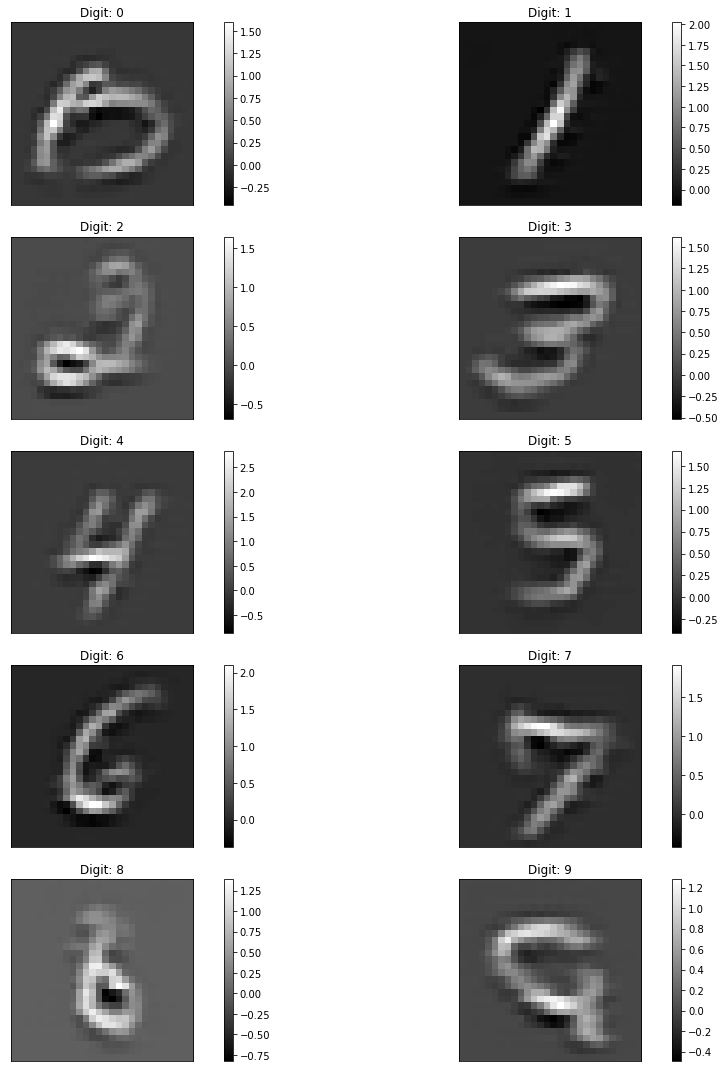

In [5]:
features = [sess.run(hmaps[i], feed_dict={X: sample_imgs[i][None]}) for i in range(10)]

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(features[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(features[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()